# Transfer Learning

Este notebook explora o conceito de Transfer Learning (Aprendizagem por Transferência), uma técnica em deep learning que consiste em reutilizar um modelo pré-treinado em uma nova tarefa. Em vez de treinar uma rede neural do zero, o que exige grandes volumes de dados e poder computacional, podemos aproveitar o conhecimento encapsulado em modelos que foram treinados em datasets massivos, como o ImageNet.

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [29]:
import requests
import zipfile
from io import BytesIO

if not os.path.exists('data/hymenoptera_data'):
    url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
    response = requests.get(url)
    with zipfile.ZipFile(BytesIO(response.content)) as z:
        z.extractall("data")
    print("Dataset 'hymenoptera_data' baixado e extraído.")
else:
    print("Dataset 'hymenoptera_data' já existe.")

Dataset 'hymenoptera_data' já existe.


In [30]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        self.data = []
        for class_name in self.class_names:
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(class_dir, filename)
                    item = (path, self.class_to_idx[class_name])
                    self.data.append(item)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [31]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'

# Criando instâncias de Dataset
train_dataset = CustomImageDataset(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = CustomImageDataset(os.path.join(data_dir, 'val'), data_transforms['val'])

# Criando instâncias de DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

# Obtendo informações
class_names = train_dataset.class_names
train_size = len(train_dataset)
val_size = len(val_dataset)

print(f"Classes: {class_names}")
print(f"Tamanho do dataset de treino: {train_size}")
print(f"Tamanho do dataset de validação: {val_size}")

Classes: ['bees', 'ants']
Tamanho do dataset de treino: 244
Tamanho do dataset de validação: 153


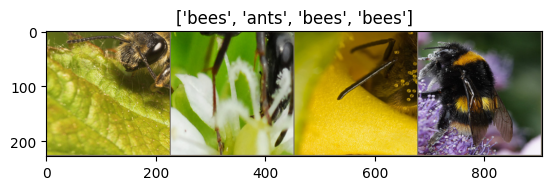

In [34]:
def imshow(inp, title=None):
    """Função para exibir um tensor de imagem."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Obtém um batch de dados de treino
inputs, classes = next(iter(train_dataloader))

# Cria uma grade a partir do batch
out = utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [35]:
from tqdm.notebook import tqdm

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        for phase, loader in [('train', train_loader), ('val', val_loader)]:
            model.train(phase == 'train')
            running_loss, running_corrects = 0.0, 0
            size = len(loader.dataset)

            loop = tqdm(loader, desc=f'{phase.capitalize()}')
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / size
            epoch_acc = running_corrects.double() / size
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

## Treinamento de um Modelo Baseline

Para entender o efeito do transfer learning, primeiro treinaremos uma rede convolucional (CNN) simples a partir do zero. Dado o tamanho reduzido do nosso dataset, é altamente provável que este modelo sofra de overfitting, o que servirá como um ponto de referência.

In [38]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

baseline_model = SimpleCNN().to(device)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=0.001)

history_baseline = train_model(
    baseline_model, criterion, optimizer_baseline, train_dataloader, val_dataloader, num_epochs=25
)


Epoch 1/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 2.1507 Acc: 0.4959


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6869 Acc: 0.5033

Epoch 2/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6698 Acc: 0.5697


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6617 Acc: 0.6013

Epoch 3/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6601 Acc: 0.5861


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6989 Acc: 0.5948

Epoch 4/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6435 Acc: 0.5861


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6982 Acc: 0.5686

Epoch 5/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6560 Acc: 0.6393


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6672 Acc: 0.6013

Epoch 6/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6244 Acc: 0.6598


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6679 Acc: 0.6209

Epoch 7/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5825 Acc: 0.6598


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6724 Acc: 0.6013

Epoch 8/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6208 Acc: 0.6557


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6656 Acc: 0.6340

Epoch 9/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5850 Acc: 0.6762


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6524 Acc: 0.6209

Epoch 10/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5625 Acc: 0.6639


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6059 Acc: 0.6797

Epoch 11/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6181 Acc: 0.6230


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6002 Acc: 0.6928

Epoch 12/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5766 Acc: 0.6803


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6351 Acc: 0.6863

Epoch 13/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5600 Acc: 0.6926


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.7160 Acc: 0.6340

Epoch 14/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5589 Acc: 0.6598


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6480 Acc: 0.6536

Epoch 15/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5863 Acc: 0.7131


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6965 Acc: 0.6078

Epoch 16/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5931 Acc: 0.6680


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.5967 Acc: 0.6209

Epoch 17/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5461 Acc: 0.7418


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.5994 Acc: 0.6797

Epoch 18/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5352 Acc: 0.7254


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6431 Acc: 0.6797

Epoch 19/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5378 Acc: 0.6885


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6807 Acc: 0.6601

Epoch 20/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5458 Acc: 0.7172


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.7076 Acc: 0.6536

Epoch 21/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6176 Acc: 0.7295


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6609 Acc: 0.6275

Epoch 22/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5622 Acc: 0.7049


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6811 Acc: 0.5948

Epoch 23/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5417 Acc: 0.7008


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6416 Acc: 0.6928

Epoch 24/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5210 Acc: 0.7418


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6412 Acc: 0.6667

Epoch 25/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5062 Acc: 0.7500


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.7054 Acc: 0.6993


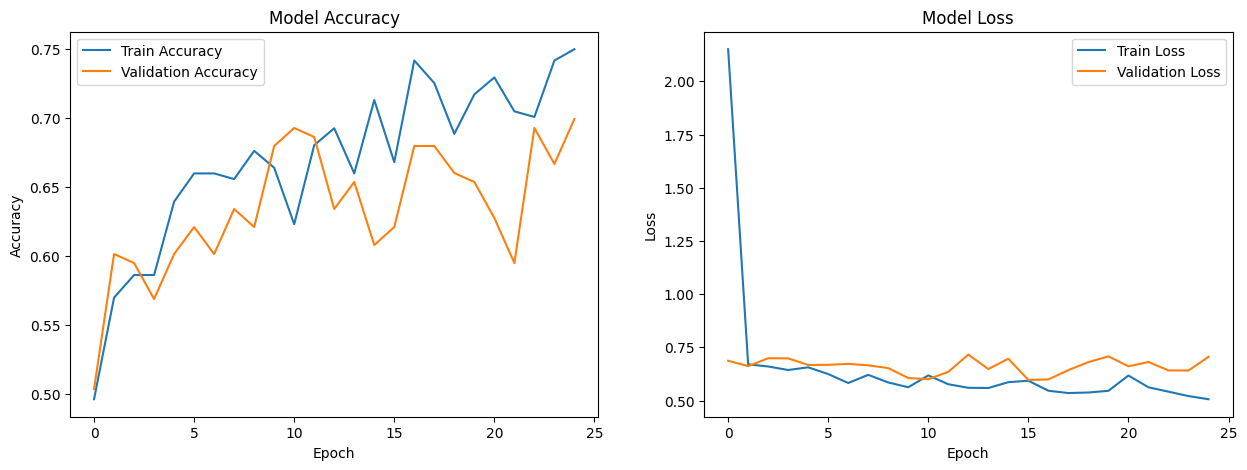

In [40]:
plot_history(history_baseline)

## Modelos Pré-treinados

O `torchvision.models` oferece acesso a diversas arquiteturas de modelos já treinados no dataset ImageNet. Esses modelos aprenderam a extrair hierarquias ricas de características (features), que podem ser aproveitadas em outras tarefas.

In [41]:
from torchvision import models

# Carregando um modelo ResNet-50 pré-treinado
weights = models.ResNet50_Weights.DEFAULT
resnet50_pretrained = models.resnet50(weights=weights)

# A última camada 'fc' (fully connected) tem 1000 saídas,
# correspondentes às 1000 classes do ImageNet.
print(resnet50_pretrained)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Usando um Modelo Pré-treinado para Inferência

Um modelo pré-treinado pode ser usado diretamente para inferência. Basta carregá-lo, colocá-lo em modo de avaliação com `.eval()` e passar uma imagem pré-processada. A saída será um vetor de scores para as 1000 classes do ImageNet.

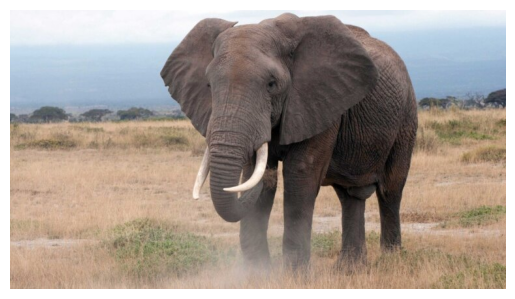

In [42]:
url = "https://www.uni-jena.de/unijenamedia/387585/elefant.jpg?height=428&width=760"
response = requests.get(url, stream=True)
img = Image.open(response.raw)

plt.imshow(img)
plt.axis('off')
plt.show()

In [43]:
preprocess = data_transforms['val']
img_tensor = preprocess(img).unsqueeze(0)

print(preprocess)
print(img_tensor.shape)

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 224, 224])


In [44]:
resnet50_pretrained.eval()
with torch.no_grad():
    output = resnet50_pretrained(img_tensor)

print(output.shape)

torch.Size([1, 1000])


In [45]:
output

tensor([[ 1.1759e-01,  2.5351e-01, -4.3408e-01,  2.9843e-01,  5.4023e-02,
          1.4534e-01, -8.5290e-02, -3.5413e-01, -6.1396e-02, -1.0305e-01,
         -9.4146e-02, -2.5369e-02,  1.6589e-02,  4.3400e-02, -6.5438e-02,
         -1.3458e-01, -3.6927e-02, -1.2346e-01, -4.4063e-01, -6.6427e-02,
          1.0259e-02,  1.2946e-01,  2.4835e-01,  3.7051e-02, -1.4907e-01,
         -4.0879e-02,  2.4834e-01, -4.4614e-01, -4.6229e-01,  8.0452e-02,
         -2.8723e-01, -8.4706e-02,  2.6754e-02, -2.3274e-01,  1.5995e-01,
         -1.0531e-01,  3.5501e-01, -2.7867e-01,  2.5260e-01, -3.0172e-01,
          5.5965e-02,  1.4031e-01,  1.2810e-01, -2.2109e-01,  1.3549e-02,
         -3.1056e-01, -2.9369e-01, -7.8635e-02,  7.6824e-02, -6.0971e-03,
         -3.0943e-01,  2.8366e-01,  2.2867e-01,  3.7379e-02, -3.5334e-02,
         -2.1532e-01, -4.5944e-01,  1.0621e-03, -4.0671e-03,  3.2039e-01,
          3.8628e-01, -4.1545e-01, -6.3288e-02,  4.1536e-01,  5.5829e-02,
          2.9522e-02,  1.6147e-01, -1.

In [46]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i in range(top5_prob.size(0)):
    print(f"Classe: {weights.meta['categories'][top5_catid[i]]}, Probabilidade: {top5_prob[i].item():.4f}")

Classe: African elephant, Probabilidade: 0.3498
Classe: tusker, Probabilidade: 0.2966
Classe: Indian elephant, Probabilidade: 0.0079
Classe: Great Dane, Probabilidade: 0.0009
Classe: promontory, Probabilidade: 0.0007


## Transfer Learning: Congelando Camadas (Freezing)

A estratégia de "feature extraction" consiste em congelar os pesos das camadas convolucionais de um modelo pré-treinado e substituir a camada de classificação final por uma nova, adequada ao nosso problema. Apenas os pesos dessa nova camada serão treinados, o que é computacionalmente eficiente e previne overfitting em datasets pequenos.

In [47]:
model_conv = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Congelar todos os parâmetros da rede
for param in model_conv.parameters():
    param.requires_grad = False

print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
num_ftrs = model_conv.fc.in_features

# Substituir a camada 'fc' por uma nova camada Linear
# Os parâmetros desta nova camada terão `requires_grad=True` por padrão
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

print("Estrutura da última camada modificada:")
print(model_conv.fc)

Estrutura da última camada modificada:
Linear(in_features=2048, out_features=2, bias=True)


## Treinando o Modelo com Transfer Learning

Agora, vamos treinar o modelo modificado. O otimizador Adam será configurado para atualizar apenas os parâmetros da nova camada de classificação. Esperamos ver uma convergência muito mais rápida e uma acurácia de validação significativamente maior em comparação com o modelo baseline.

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Treinar o modelo
history_conv = train_model(
    model_conv, criterion, optimizer_conv, train_dataloader, val_dataloader, num_epochs=5
)


Epoch 1/5


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5629 Acc: 0.7500


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.3482 Acc: 0.9477

Epoch 2/5


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4429 Acc: 0.8238


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2535 Acc: 0.9412

Epoch 3/5


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3558 Acc: 0.8648


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1957 Acc: 0.9673

Epoch 4/5


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3704 Acc: 0.8361


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2016 Acc: 0.9542

Epoch 5/5


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.2714 Acc: 0.8811


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1536 Acc: 0.9673


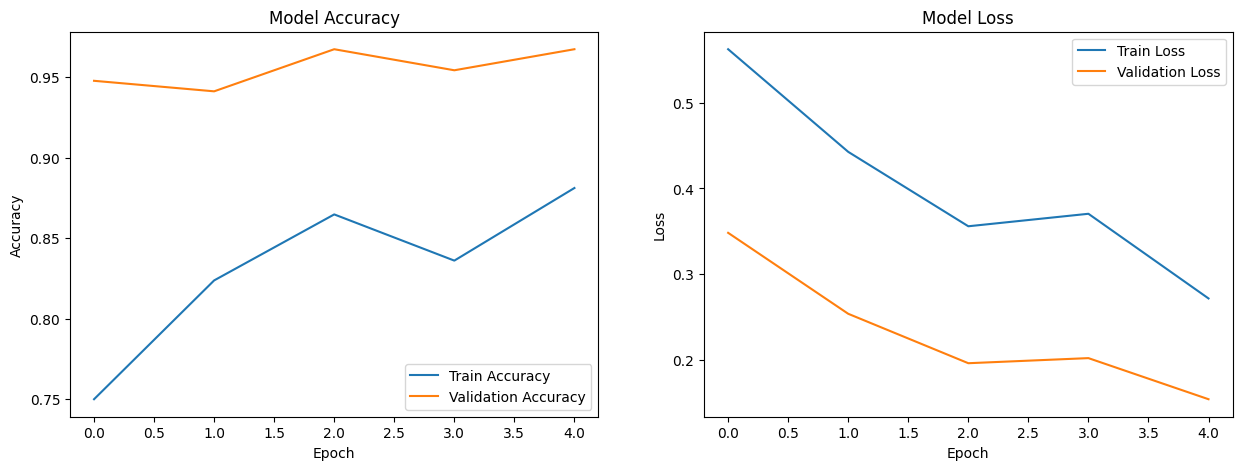

In [50]:
plot_history(history_conv)